In [1]:
import shap
import plotly.express as px

from steps.imports import ImportData
from steps.preprocess import PreprocessData
from steps.model import ModelChurn
from steps.export import ExportData

In [2]:
paths_dict = {
    'churn_labels': 'data/churn_labels.csv',
    'claims': 'data/claims.csv', 
    'app_usage': 'data/app_usage.csv', 
    'web_visits': 'data/web_visits.csv',
}

raw_data = ImportData(paths_dict)
raw_data._execute()

In [3]:
preprocess_data = PreprocessData(raw_dfs=raw_data.dfs)
preprocess_data._execute()

In [4]:
xgboost_model = ModelChurn(churn_labels_df=preprocess_data.labels_df)
model, selected_features, X_test, y_test, y_pred_tuned, y_prob = xgboost_model._execute()

Selected features: ['icd_A09', 'icd_E11.9', 'icd_H10.9', 'icd_I10', 'icd_K21.9', 'icd_M54.5', 'icd_Z71.3', 'web_Budget planning', 'web_Exercise routines', 'web_Meditation guide']
Best threshold by f1: 0.02 with score: 0.338
Tuned threshold model performance:
              precision    recall  f1-score   support

           0       0.86      0.03      0.05      2659
           1       0.20      0.98      0.34       674

    accuracy                           0.22      3333
   macro avg       0.53      0.50      0.20      3333
weighted avg       0.73      0.22      0.11      3333

ROC AUC: 0.5368118801494951


In [5]:
path = 'export/exported_members.csv'
export_data = ExportData(path=path,
                 churn_labels_df=preprocess_data.labels_df,
                 selected_features=selected_features,
                 model=model,
                 prob_threshold=0.5)
members_list_df = export_data._execute()

30 members exported to export/exported_members.csv


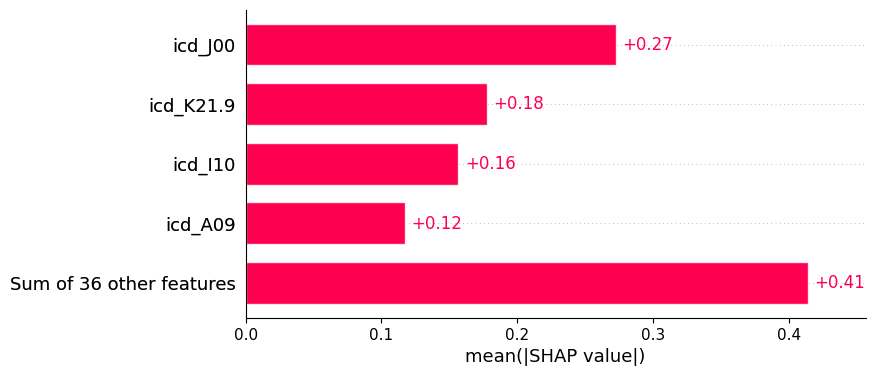

In [ ]:
### SHAP Analysis - top 5 features

explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

shap.plots.bar(shap_values, max_display=5)

In [ ]:
### precision and recall analysis for top N customers in test set

results = []
df_ranked = X_test.copy()
df_ranked['churn'] = y_prob
df_ranked = df_ranked.sort_values(by='churn', ascending=False).reset_index(drop=True).reset_index()

for n in range(1, 1001, 1):
    top_n = df_ranked.head(n)
    precision = top_n['churn'].sum() / n
    recall = top_n['churn'].sum() / df_ranked['churn'].sum()
    
    results.append({'n': n, 'precision': precision, 'recall': recall})

px.line(results, x='n', y=['precision', 'recall'], markers=True, title='Precision and Recall vs N', labels={'value': 'Score', 'n': 'Top N Customers', 'variable': 'Metric'})

In [ ]:
### Churn Risk Scores for Live Members, the threshold for reachout is 50%

px.line(members_list_df, x='index', y='churn_risk', title='Churn Risk Scores for Live Members')